In [1]:
# here is how we activate an environment in our current directory
import Pkg; Pkg.activate(@__DIR__); Pkg.add("CircleFit"); Pkg.add("StatsBase");

# instantate this environment (download packages if you haven't)
Pkg.instantiate();

using Test, LinearAlgebra
import ForwardDiff as FD 
import FiniteDiff as FD2 
using CircleFit
using Plots
using StatsBase
import Convex as cvx
import ECOS

  Activating project at `~/Downloads/MSR Academics/zoe2_optimal_controller/julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Downloads/MSR Academics/zoe2_optimal_controller/julia/Project.toml`
  No Changes to `~/Downloads/MSR Academics/zoe2_optimal_controller/julia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Downloads/MSR Academics/zoe2_optimal_controller/julia/Project.toml`
  No Changes to `~/Downloads/MSR Academics/zoe2_optimal_controller/julia/Manifest.toml`


In [2]:
function dynamics(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ϕ = x[1:3]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B

    ϵ = 1e-6
    # R = (L/4)*((1/(tan(f_steerθ)+ϵ))+(1/(tan(r_steerθ)+ϵ)))
    V_l = (r/2)*(ω_fl+ω_rl)
    V_r = (r/2)*(ω_fr+ω_rr)
    R = (L/2)*(V_l+V_r)/(V_r-V_l+ϵ)
    f_steerθ = atan(L/(2*R+ϵ))
    r_steerθ = atan(L/(2*R+ϵ))

    ## Full Computation
    v = (r/4)*((ω_fl/cos(f_steerθ))+ (ω_fr/cos(f_steerθ))+ (ω_rl/cos(r_steerθ)) + (ω_rr/cos(r_steerθ)))

    ## Small Angle Approximation
    # v = (r/8)*(2+(L/(2*R+ϵ))^2)*(ω_fl+ω_fr+ω_rl+ω_rr)

    xdot = [v*cos(ϕ); v*sin(ϕ); v/(R+ϵ)]
    
    return xdot
end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)

    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

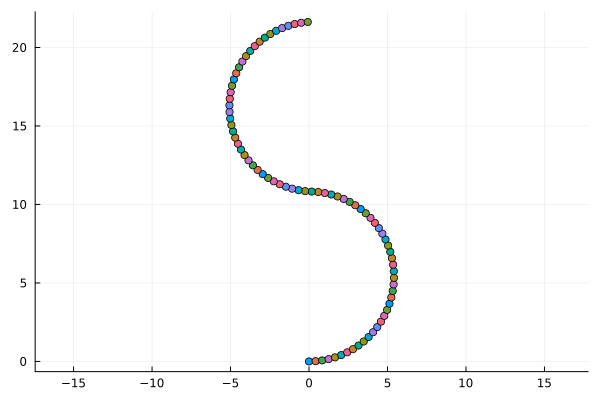

In [3]:
params = (r = 0.325, L = 1.91, B = 1.64)
u = [1.05, 1.5, 1.05, 1.5]

x0 = [0,0,0]
nx = 3
N = 80
dt = 1.0
t_vec = 0:dt:((N-1)*dt)

X = [zeros(nx) for i = 1:N]
X[1] = x0
for i = 1:(N-1)
    X[i+1] = rk4(params, X[i], u, dt)
    if i % 40 == 0
        u = [u[2],u[1],u[4],u[3]]
    end
end

X = hcat(X...)
x = X[1,:]
y = X[2,:]
# print(y[2]-y[1])
# result = fit(Circle,x,y)
# @show coef(result)
# @show coefnames(result)
# @show rss(result)

display(scatter(X[1,:]', X[2,:]', legend=false, aspect_ratio=:equal))

In [4]:
### Traj Loading
function create_reference()
    # create reference trajectory for quadrotor 
    X_ref = [zeros(3) for i = 1:80]
    U_ref = [[1.05, 1.5, 1.05, 1.5] for i = 1:79]

    open("../spline_test.txt") do f
        line = 1
        while !eof(f)
            x = readline(f)
            x, y = split(x, ',')
            X_ref[line] = [parse(Float64, x),parse(Float64, y), pi/8]
            if line >= 41 && line != 80
                U_ref[line] = [U_ref[line][2],U_ref[line][1],U_ref[line][4],U_ref[line][3]]
            end
            line += 1
        end
    end
    return X_ref, U_ref;
end

create_reference (generic function with 1 method)

In [5]:
# starter code: feel free to use or not use 

function stage_cost(p::NamedTuple,x::Vector,u::Vector,k::Int)
    # TODO: return stage cost at time step k 
    xref = p.Xref[k]
    uref = p.Uref[k]
    delta_x = x[1:2] - xref[1:2]  # Difference in position (x and y)
    delta_phi = atan(sin(x[3] - xref[3]), cos(x[3] - xref[3]))  # Smallest angular difference

    # Stage cost for positions and angle
    stage_cost = 0.5 * delta_x' * p.Q[1:2, 1:2] * delta_x + 0.5 * delta_phi^2 * p.Q[3, 3] +
                 0.5 * (u - uref)' * p.R * (u - uref)
    return stage_cost
end
function term_cost(p::NamedTuple,x)
    # TODO: return terminal cost
    xref = p.Xref[p.N]
    delta_x = x[1:2] - xref[1:2]  # Difference in position (x and y)
    delta_phi = atan(sin(x[3] - xref[3]), cos(x[3] - xref[3]))  # Smallest angular difference

    # Stage cost for positions and angle
    term_cost = 0.5 * delta_x' * p.Qf[1:2, 1:2] * delta_x + 0.5 * delta_phi^2 * p.Qf[3, 3]
    return term_cost
end
function stage_cost_expansion(p::NamedTuple, x::Vector, u::Vector, k::Int)
    # TODO: return stage cost expansion
    # if the stage cost is J(x,u), you can return the following
    # ∇ₓ²J, ∇ₓJ, ∇ᵤ²J, ∇ᵤJ
    ∇ₓJ = FD.gradient(_x -> stage_cost(p, _x, u, k), x)
    ∇ₓ²J = FD.hessian(_x -> stage_cost(p, _x, u, k), x)
    ∇ᵤJ = FD.gradient(_u -> stage_cost(p, x, _u, k), u)
    ∇ᵤ²J = FD.hessian(_u -> stage_cost(p, x, _u, k), u)
    return (∇ₓJ, ∇ₓ²J, ∇ᵤJ, ∇ᵤ²J)
end
function term_cost_expansion(p::NamedTuple, x::Vector)
    # TODO: return terminal cost expansion
    # if the terminal cost is Jn(x,u), you can return the following
    # ∇ₓ²Jn, ∇ₓJn
    ∇ₓJn = FD.gradient(_x -> term_cost(p, _x), x)
    ∇ₓ²Jn = FD.hessian(_x -> term_cost(p, _x), x)
    return (∇ₓJn, ∇ₓ²Jn)
end
function backward_pass(params::NamedTuple,          # useful params 
                       X::Vector{Vector{Float64}},  # state trajectory 
                       U::Vector{Vector{Float64}})  # control trajectory 
    # compute the iLQR backwards pass given a dynamically feasible trajectory X and U
    # return d, K, ΔJ  
    
    # outputs:
    #     d  - Vector{Vector} feedforward control  
    #     K  - Vector{Matrix} feedback gains 
    #     ΔJ - Float64        expected decrease in cost 
    
    nx, nu, N = params.nx, params.nu, params.N 
    
    # vectors of vectors/matrices for recursion 
    P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
    p = [zeros(nx)    for i = 1:N]   # cost to go linear term
    d = [zeros(nu)    for i = 1:N-1] # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

    # TODO: implement backwards pass and return d, K, ΔJ 
    N = params.N
    ΔJ = 0.0
    P[N] = term_cost_expansion(params, X[end])[2]
    p[N] = term_cost_expansion(params, X[end])[1]
    for k = (N-1):-1:1
        A = FD.jacobian(_x -> rk4(params.model, _x, U[k], params.dt), X[k])
        B = FD.jacobian(_u -> rk4(params.model, X[k], _u, params.dt), U[k])
        ### Need to change to reduce versions to handle quaternions?

        (∇ₓJ, ∇ₓ²J, ∇ᵤJ, ∇ᵤ²J) = stage_cost_expansion(params, X[k], U[k], k)
        gx = ∇ₓJ + A'*p[k+1]
        gu = ∇ᵤJ + B'*p[k+1]
        Gxx = ∇ₓ²J + A'*P[k+1]*A
        Guu = ∇ᵤ²J + B'*P[k+1]*B
        Gxu = A'*P[k+1]*B
        Gux = B'*P[k+1]*A

        d[k] = Guu\gu
        K[k] = Guu\Gux
        P[k] = Gxx+K[k]'*Guu*K[k]-Gxu*K[k]-K[k]'*Gux
        p[k] = gx-K[k]'*gu+K[k]'*Guu*d[k]-Gxu*d[k]

        ΔJ += gu'*d[k]
    end

    return d, K, ΔJ
end

function trajectory_cost(params::NamedTuple,          # useful params 
                         X::Vector{Vector{Float64}},  # state trajectory 
                         U::Vector{Vector{Float64}}) # control trajectory 
    # compute the trajectory cost for trajectory X and U (assuming they are dynamically feasible)
    N = params.N
    # TODO: add trajectory cost
    cost = 0
    for i = 1:(N-1)
        cost += stage_cost(params, X[i], U[i], i)
    end
    cost += term_cost(params, X[N])
    return cost 
end

function forward_pass(params::NamedTuple,           # useful params 
                      X::Vector{Vector{Float64}},   # state trajectory 
                      U::Vector{Vector{Float64}},   # control trajectory 
                      d::Vector{Vector{Float64}},   # feedforward controls 
                      K::Vector{Matrix{Float64}},   # feedback gains
                      ΔJ;   
                      max_linesearch_iters = 75)    # max iters on linesearch 
    # forward pass in iLQR with linesearch 
    # use a line search where the trajectory cost simply has to decrease (no Armijo)
    
    # outputs:
    #     Xn::Vector{Vector}  updated state trajectory  
    #     Un::Vector{Vector}  updated control trajectory 
    #     J::Float64          updated cost  
    #     α::Float64.         step length 

    nx, nu, N = params.nx, params.nu, params.N 
    
    Xn = [zeros(nx) for i = 1:N]      # new state history 
    Un = [zeros(nu) for i = 1:N-1]    # new control history 
    
    # initial condition 
    Xn[1] = 1*X[1]

    Jref = trajectory_cost(params, X,U)
    Jn = deepcopy(Jref)
    
    # initial step length 
    α = 1.0
    
    # TODO: add forward pass 
    for i = 1:max_linesearch_iters
        if Jn < Jref-1e-2*α*ΔJ
            return Xn, Un, Jn, α
        end
        α *= 0.5
        for k = 1:(N-1)
            Un[k] = U[k]-α*d[k]-K[k]*(Xn[k]-X[k])
            Xn[k+1] = rk4(params.model, Xn[k], Un[k], params.dt)
            
            Xn[k+1][3] = Xn[k+1][3] % 2*π
            if Xn[k+1][3] < 0
                Xn[k+1][3] += 2*π
            end
        end
        Jn = trajectory_cost(params, Xn,Un)
        @show Jn-Jref, α
    end

    error("forward pass failed")
end

forward_pass (generic function with 1 method)

In [6]:
function iLQR(params::NamedTuple,         # useful params for costs/dynamics/indexing 
              x0::Vector,                 # initial condition 
              U::Vector{Vector{Float64}}; # initial controls 
              atol=1e-3,                  # convergence criteria: ΔJ < atol 
              max_iters = 250,            # max iLQR iterations 
              verbose = true)             # print logging
    
    # iLQR solver given an initial condition x0, initial controls U, and a 
    # dynamics function described by `discrete_dynamics`
    
    # return (X, U, K) where 
    # outputs:
    #     X::Vector{Vector} - state trajectory 
    #     U::Vector{Vector} - control trajectory 
    #     K::Vector{Matrix} - feedback gains K 

    # first check the sizes of everything
    @assert length(U) == params.N-1
    @assert length(U[1]) == params.nu
    @assert length(x0) == params.nx 

    nx, nu, N = params.nx, params.nu, params.N

    # TODO: initial rollout
    X = [zeros(nx) for i = 1:N] 
    X[1] = 1*x0
    for k = 1:(N-1)
        X[k+1] = rk4(params.model, X[k], U[k], params.dt)
    end

    for ilqr_iter = 1:max_iters
        d, K, ΔJ = backward_pass(params, X, U)
        X, U, J, α = forward_pass(params, X, U, d, K, ΔJ)
        @show ΔJ
        
        # termination criteria 
        if ΔJ < atol
            return X, U, K 
        end
        
    end
    error("iLQR failed")
end

iLQR (generic function with 1 method)

In [7]:
function solve_quadrotor_trajectory(;verbose = true)
    
    # problem size 
    nx = 3
    nu = 4
    dt = 1.0 
    N = 80
    t_vec = 0:dt:((N-1)*dt)

    # create reference trajectory 
    Xref, Uref = create_reference()
    
    # tracking cost function
    Q = .1*diagm([1*ones(nx-1);1e-4*ones(1)])
    R = .001*diagm(ones(nu))
    Qf = 100*Q 

    # dynamics parameters (these are estimated)
    model = (r = 0.325,
            L = 1.91,
            B = 1.64)

    
    # the params needed by iLQR 
    params = (
        N = N, 
        nx = nx, 
        nu = nu, 
        Xref = Xref, 
        Uref = Uref, 
        Q = Q, 
        R = R, 
        Qf = Qf, 
        model = model,
        dt = dt
    )

    # initial condition 
    x0 = 1*Xref[1]
    
    # initial guess controls 
    U = [(uref + 0.001*randn(nu)) for uref in Uref]
    
    # solve with iLQR
    X, U, K = iLQR(params,x0,U;atol=500,max_iters = 250,verbose = verbose)
    
    return X, U, K, t_vec, params
end

solve_quadrotor_trajectory (generic function with 1 method)

In [8]:
Xilqr, Uilqr, Kilqr, t_vec, params =  solve_quadrotor_trajectory(verbose = false)
@show Xilqr

(Jn - Jref, α) = (1.0427462857368803e7, 0.5)
(Jn - Jref, α) = (1851.3146261013549, 0.25)
(Jn - Jref, α) = (111519.05712666652, 0.125)
(Jn - Jref, α) = (1642.4477807381509, 0.0625)
(Jn - Jref, α) = (122884.89750391223, 0.03125)
(Jn - Jref, α) = (2847.9978705922676, 0.015625)
(Jn - Jref, α) = (122.76213200084112, 0.0078125)
(Jn - Jref, α) = (-22.372443425241386, 0.00390625)
ΔJ = 911.1939140901617
(Jn - Jref, α) = (2490.0389490265884, 0.5)
(Jn - Jref, α) = (519.2278821674352, 0.25)
(Jn - Jref, α) = (138508.9244014197, 0.125)
(Jn - Jref, α) = (1118.739512030361, 0.0625)
(Jn - Jref, α) = (1.2367309314284818e8, 0.03125)
(Jn - Jref, α) = (46157.3847572234, 0.015625)
(Jn - Jref, α) = (7787.662525394571, 0.0078125)
(Jn - Jref, α) = (5430.915160955599, 0.00390625)
(Jn - Jref, α) = (3.0109247679483768e7, 0.001953125)
(Jn - Jref, α) = (27137.140726512855, 0.0009765625)
(Jn - Jref, α) = (18740.66292499482, 0.00048828125)
(Jn - Jref, α) = (112416.72363503605, 0.000244140625)
(Jn - Jref, α) = (1.1869

LoadError: forward pass failed